In [1]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc
from scipy import stats

from src.utils import parse_filename, normalize

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

## Configuration

In [2]:
data_name = "100_100_100_0.2_0.05_0.03_0.5_0.5_d.npy"
out_name = "100_100_100_0.2_0.05_0.03_0.5_0.5_o.npy"
data = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params = parse_filename(data_name)
params

{'num_devices': 100,
 'n': 100,
 'dims': 100,
 'subspace_frac': 0.2,
 'frac_outlying_devices': 0.05,
 'frac_outlying_data': 0.03,
 'gamma': 0.5,
 'delta': 0.5}

In [3]:
num_devices = params["num_devices"]
dims = params["dims"]
num_data = params["n"]
subspace_frac = ["subspace_frac"]
frac_outlying_devices = params["frac_outlying_devices"]
frac_outlying_data = params["frac_outlying_data"]

T_start = 1
T = 9
n = int(num_data/(T_start+T))

## Model Creation

In [45]:
# LOF Training
predictions = np.array([])
central_data = np.array([])
labels = np.array([])
for t in range(T_start, T+1):
    print("t = {}".format(t))
    start = t*n
    end = (t+1)*n
    # send data to central server
    cdata = data[:, start:end]
    prev_shape = cdata.shape
    cdata = np.reshape(cdata, newshape=(cdata.shape[0]*cdata.shape[1], cdata.shape[2]))
    cout = is_outlier[:, start:end].any(axis=-1).flatten()

    # predict
    new_predictions = stats.zscore(cdata.T, axis=-1).T
    pred_reshape = np.reshape(new_predictions, newshape=prev_shape)
    predictions = pred_reshape if t == 1 else np.concatenate((predictions, pred_reshape))
    central_data = cdata if not len(central_data) else np.concatenate((central_data, cdata))
    labels = cout if not len(labels) else np.concatenate((labels, cout))
predictions = np.reshape(predictions, newshape=data[:, n*T_start:].shape)
predictions.shape

t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9


(100, 90, 100)

(100, 90)
(100, 90)


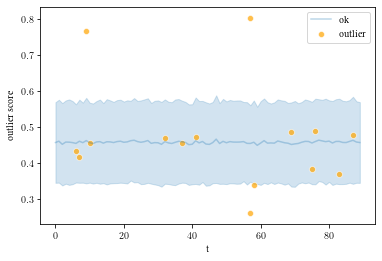

In [46]:
diff = predictions
dist = np.linalg.norm(predictions, axis=-1)
dist = dist/np.max(dist)

labels = is_outlier[:, T_start*n:].any(axis=-1)

print(dist.shape)
print(labels.shape)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band", alpha=0.3)
sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("t")
plt.ylabel("outlier score")
plt.legend()
plt.show()

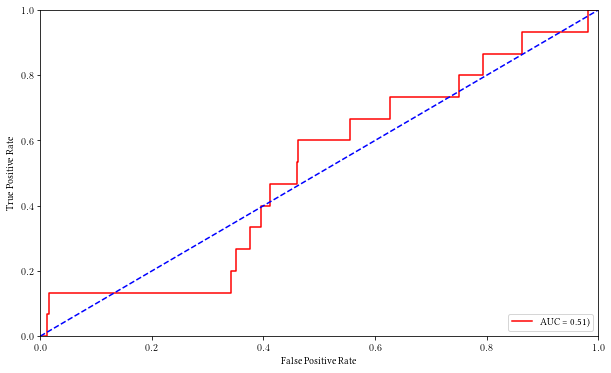

In [29]:
fpr, tpr, thresholds = roc_curve(labels.flatten(), dist.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")
plt.show()